In [30]:
import btk
import dataset_generators as dgen
import cv2 as cv
import numpy as np
import random
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageGrab, PngImagePlugin
from spellchecker import SpellChecker

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(f"{os.environ['style']}")

In [19]:
tdet = tf.keras.models.load_model('models\\tdet-3')
tseg = tf.keras.models.load_model('models\\tseg-0')
tcls = tf.keras.models.load_model('models\\tcls-3')
chars = list('abcdefghijklmnopqrstuvwxyzABDEFGHIJKLMNQRTUY0123456789 ')

In [40]:

def txt_detect(img: np.ndarray, sdims: tuple[int, int], sens: float, sfactor: float = True) -> tuple[int, ...]:
    """
    Use ML model to determine if text appears within an image

    Args:
        img (np.ndarray): Image to analyze
        sens (float): Sensitivity threshold for text detection 

    Returns:
        list[tuple[int, ...], np.ndarray]: Coordinates of regions that have text within the image
    """
    if sfactor:
        sfactor = img.size
    oshape = img.shape
    sc_coeff = (sfactor / img.size)**0.5
    img = btk.resize(img, (round(img.shape[0] * sc_coeff), round(img.shape[1] * sc_coeff)))
    img = btk.fit2dims(img, sdims)
    coord_scale = ((oshape[0] / img.shape[0], oshape[1] / img.shape[1]))
    slices = btk.img_slicer(img, sdims, sdims, 2)
    coords = btk.gen_index(img.shape, sdims, sdims, 2)
    predictions = tdet.predict(slices)
    tcords = []
    for i, x in enumerate(predictions):
        if x > sens:
            tcords.append((coords[i], x[0]))
    #display(drawbox(Image.fromarray(img), [x[0] for x in tcords]))
    for i, x in enumerate(tcords):
        tcords[i] = (np.array([x[0][0] * coord_scale[0],
                            x[0][1] * coord_scale[0],
                            x[0][2] * coord_scale[1],
                            x[0][3] * coord_scale[1]]).astype('uint16'), x[1])
    return tcords

def txt_heat_mapper(img: np.ndarray, sdims: tuple[int, int], sens: float) -> np.ndarray:
    """Generates a heatmap for text locations on an image"""
    img = btk.fit2dims(img, sdims)
    iarea = img.size
    score_card = np.zeros((img.shape[0], img.shape[1]), dtype='float16')
    """ if iarea < 1048576:
        cords = txt_detect(img, sdims, sens - ((1 - sens) - ((1 - sens) ** 1.666)), iarea * 4)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1]) """
    if iarea < 2097152:
        cords = txt_detect(img, sdims, sens - ((1 - sens) - ((1 - sens) ** 1.333)), iarea * 2)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    cords = txt_detect(img, sdims, sens, iarea)
    for x in cords:
        score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    if iarea > 2097152:
        cords = txt_detect(img, sdims, sens ** 0.666, iarea / 2)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    """ if iarea > 4194304:
        cords = txt_detect(img, sdims, sens ** 0.333, iarea / 4)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1]) """
    """ img = btk.fit2dims(img, (64, 64))
    combined = cv.addWeighted(img, 0.3, score_card.astype('uint8') * 50, 0.7, 1)
    display(Image.fromarray(combined)) """
    return score_card

def textract_images(img: np.ndarray, coords: tuple[int, ...]) -> list[np.ndarray]:
    """Extract image regions defineed by coordinate list input"""
    imarr = np.array(img)
    extracted = [imarr[x[0]:x[1], x[2]:x[3]] for x in coords]
    return extracted

def trimmer(iar):
    img = np.array(iar)
    hgram = np.histogram(img.flatten(), 255, (0, 255))
    pix_mode = hgram[0].argmax()
    if pix_mode > 127:
        img = np.invert(img)
        pix_mode = 255 - pix_mode
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 21, 29)
    img = np.invert(img)
    img = cv.medianBlur(img, 3)
    img[img < 127] = 0
    img[img > 0] = 255
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=-1)
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=1)
    img = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=1)
    img = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=-1)
    img = np.uint8(np.absolute(img))
    img = cv.medianBlur(img, 3)
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=-1)
    img = np.uint8(np.absolute(img))
    img = cv.erode(img, np.ones((2, 2)), iterations=1)
    img = cv.GaussianBlur(img, (9, 1), 9, 1)
    display(Image.fromarray(img))
    img = cv.morphologyEx(img, cv.MORPH_OPEN, np.ones((2, 2), np.uint8), iterations=2)
    img[img > 0] = 255
    img = cv.GaussianBlur(img, (7, 1), 7, 1)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=1)
    img[img > 0] = 255
    display(Image.fromarray(img))
    bounds = contour_bounds(img)
    bounds = expand_coordinates(bounds, iar.shape, (0.06, 0.03))
    for x in bounds.copy():
        if x[1] - x[0] + 6 > x[3] - x[2]:
            if x[3] - x[2] < 128:
                bounds.remove(x)
    for x in bounds.copy():
        for y in bounds.copy():
            if x[0] > y[0] and x[1] < y[1] and x[2] > y[2] and x[3] < y[3]:
                try:
                    bounds.remove(x)
                except: ValueError
    bounds = [(iar[x[0]:x[1], x[2]:x[3]], x) for x in bounds]
    for x in bounds:
        display(Image.fromarray(x[0]))
    return bounds

def dedupe(texts, img):
    for z in texts.copy().items():
        if z[1].size < 32768:
            if not sat_check(z[1]):
                texts.pop(z[0])
    for z1 in texts.copy().keys():
        for z2 in texts.copy().keys():
            if z1[1] > z2[0] and z1[0] < z2[1] and z1[3] > z2[2] and z1[2] < z2[3] and z2 != z1:
                overlap = (min(z1[1], z2[1]) - max(z1[0], z2[0])) * (min(z1[3], z2[3]) - max(z1[2], z2[2]))
                overlap_1 = overlap / ((z1[3] - z1[2]) * (z1[1] - z1[0]))
                overlap_2 = overlap / ((z2[3] - z2[2]) * (z2[1] - z2[0]))
                if overlap_1 > 0.5 or overlap_2 > 0.5:
                    if overlap_2 > overlap_1:
                        outer = z1
                        inner = z2
                    else:
                        outer = z2
                        inner = z1
                    olcoef = min(overlap_1, overlap_2) / max(overlap_1, overlap_2)
                    if olcoef <= 0.15:
                        try:
                            texts.pop(inner)
                        except: ValueError
                    elif 0.15 < olcoef < 0.666:
                        try:
                            texts.pop(outer)
                        except: ValueError
                    elif olcoef > 0.666:
                        try:
                            texts.pop(outer)
                            texts.pop(inner)
                        except: ValueError
                        texts.update({(min(z1[0], z2[0]), max(z1[1], z2[1]), min(z1[2], z2[2]), max(z1[3], z2[3])):
                                    img[min(z1[0], z2[0]):max(z1[1], z2[1]), min(z1[2], z2[2]):max(z1[3], z2[3])]})
    return texts

def get_text(img: np.ndarray, sdims: tuple[int, int], sens: float) -> list[np.ndarray]:
    """
    Identify and extract image regions containing text

    Args:
        img (np.ndarray): Image
        sdims (tuple[int, int]): Dimensions of the image slices
        sens (float): Sensitivity of the detection model

    Returns:
        list[np.ndarray]: Image regions containing text in array form
    """
    iar = btk.grey_np(img)
    img = cv.adaptiveThreshold(iar, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 17, 15)
    img = np.invert(img)
    img = cv.medianBlur(img, 3)
    img[img < 127] = 0
    img[img > 0] = 255
    display(Image.fromarray(img))
    mtrx = txt_heat_mapper(img, sdims, sens)
    img = np.rot90(img, 2)
    mtrx += np.rot90(txt_heat_mapper(img, sdims, sens), 2)
    img = cv.adaptiveThreshold(iar, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 17, 21)
    display(Image.fromarray(img))
    img = cv.medianBlur(img, 3)
    mtrx += txt_heat_mapper(img, sdims, sens)
    img = np.rot90(img, 2)
    mtrx += np.rot90(txt_heat_mapper(img, sdims, sens), 2)
    mtrx = np.array(mtrx, dtype='uint8')
    display(Image.fromarray(mtrx * 15))
    img = btk.fit2dims(iar, (64, 64))
    combined = cv.addWeighted(img, 0.3, mtrx * 15, 0.7, 1)
    display(Image.fromarray(combined))
    hgram = np.histogram(mtrx.flatten(), 9)
    mtrx[mtrx < hgram[1][hgram[0].argmin()]] = 0
    mtrx[mtrx > 0] = 255
    mtrx = cv.GaussianBlur(mtrx, (45, 27), 49)
    mtrx[mtrx > 0] = 255
    display(Image.fromarray(mtrx))
    boxes = contour_bounds(mtrx)
    for x in boxes.copy():
        for y in boxes.copy():
            if x[0] > y[0] and x[1] < y[1] and x[2] > y[2] and x[3] < y[3]:
                try:
                    boxes.remove(x)
                except: ValueError
    iar = btk.fit2dims(iar, (64, 64))
    boxes = [(iar[x[0]:x[1], x[2]:x[3]], x) for x in boxes]
    for x in boxes:
        display(Image.fromarray(x[0]))
    txt_areas = {}
    for x in boxes:
        for y in trimmer(x[0]):
            txt_areas.update({(y[1][0] + x[1][0], y[1][1] + x[1][0], y[1][2] + x[1][2], y[1][3] + x[1][2]): y[0]})
    return txt_areas

def search_read(img, sens1, sens2):
    img = np.asarray(img)
    for tarea in get_text(img, (64, 64), sens1).items():
        texts = extract_rows(tarea)
        if texts:
            img = btk.fit2dims(btk.grey_np(img), (64, 64))
            rows = dedupe(texts, img)
            for row in rows.items():
                display(Image.fromarray(row[1]))
                lpack = split_letters(row[1], (64, 12), sens1, sens2)
                if lpack:
                    ctest = ccls.predict(np.array(lpack))
                    word = []
                    for letter in ctest:
                        word.append(dgen.chars_cased[letter.argmax()])
                    print(''.join(word).lower())


In [91]:
def contour_bounds(img) -> list[tuple[np.ndarray, list]]:
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    #display(htree)
    #display(conts)
    #imc = cv.drawContours(cv.cvtColor(img, cv.COLOR_GRAY2BGR), conts, -1, (0,255,0), 2)
    #display(Image.fromarray(imc))
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
        bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 512 and x[1] - x[0] > 6]
    return bounds

def expand_coordinates(bounds: tuple[int, ...], idims: tuple[int, int], stretch: tuple[float, float] = (0.085, 0.085)) -> tuple[int, ...]:
    """Expands coordinate inputs slightly to account for imprecise text detection"""
    for i, x in enumerate(bounds):
        ygap = (x[1] - x[0]) * stretch[0]
        xgap = (x[3] - x[2]) * stretch[1]
        bounds[i] = [round(x[0] - (ygap * 1.5)), round(x[1] + (ygap * 0.5)), round(x[2] - xgap), round(x[3] + xgap)]
    for i, x in enumerate(bounds):
        if x[0] < 0:
            bounds[i][0] = 0
        if x[1] > idims[0]:
            bounds[i][1] = idims[0]
        if x[2] < 0:
            bounds[i][2] = 0
        if x[3] > idims[1]:
            bounds[i][3] = idims[1]
    return bounds

def sat_check(img):
    img = cv.Canny(img, 50, 200, apertureSize=3)
    img = cv.GaussianBlur(img, (9, 1), 9)
    img = cv.GaussianBlur(img, (1, 5), 5)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=4)
    img[img > 0] = 255
    if np.sum(img) / (img.size * 255) > 0.5:
        return True

def drawbox(img: Image, coords: list) -> Image:
    for x in coords:
        ImageDraw.Draw(img).rectangle((x[2], x[0], x[3], x[1]), outline=127, width=3)
    return img

def draw_sep(img, seps):
    img = Image.fromarray(img)
    ymax = img.size[1]
    for x in seps:
        ImageDraw.Draw(img).line([x, 0, x, ymax], 127, 1)
    return img

def sp_predict(slices, sens):
    preds = np.array([x[0] for x in tseg.predict(slices)])
    preds[preds < sens] = 0
    return preds

def extract_rows(imset, font_scale: float = 1):
    img = imset
    blur_coef_1, blur_coef_2 = btk.odder(3 * font_scale), btk.odder(1 * font_scale)
    img = cv.Canny(img, 50, 200, apertureSize=3)
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=1)
    img = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=1)
    img = np.uint8(np.absolute(img))
    img = cv.GaussianBlur(img, (blur_coef_1, blur_coef_1), 35)
    img = cv.GaussianBlur(img, (blur_coef_1, blur_coef_2), 35)
    img = cv.GaussianBlur(img, (blur_coef_1, blur_coef_2), 35)
    img[img > 0] = 255
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
    #Filter
    bounds = [x for x in bounds if btk.find_area(x) > 512 * font_scale and x[1] - x[0] > 6 * font_scale]
    bounds = expand_coordinates(bounds, imset.shape, (0.08, 0.02))
    bounds = {(x[0], x[1], x[2], x[3]): imset[x[0]:x[1], x[2]:x[3]] for x in bounds}
    for x in bounds.copy():
        #Filters
        img = bounds.get(x)
        if len([x for x in np.histogram(img.flatten(), 255, (0, 255))[0] if x > 3]) >= 176:
            #display('removed visual', Image.fromarray(img))
            bounds.pop(x)
        else:
            img = cv.Canny(img, 50, 200, apertureSize=3)
            img = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=1)
            img = np.uint8(np.absolute(img))
            if np.sum(img) / img.size < 32:
                #display('removed visual', Image.fromarray(img))
                bounds.pop(x)
    return bounds

def chopper(img_1, inp: list):
    inp.sort()
    sliced_letters = {}
    inp.insert(0, 0)
    if inp[-1] - len(inp) >= 32:
        inp.append(inp[-1] + 32)
    else:
        inp.append(len(img_1[0]) - 1)
    for i, x in enumerate(inp[:-1].copy()):
        if 64 <= inp[i + 1] - x < 128:
            inp.append(round(((inp[i + 1] - x) / 2) + x))
        if 128 <= inp[i + 1] - x < 192:
            inp.append(round(((inp[i + 1] - x) / 3) + x))
            inp.append(round((((inp[i + 1] - x) / 3) * 2) + x))
    inp = sorted(inp)
    for i, x in enumerate(inp[:-1]):
        sliced_letters.update({i: img_1[:, x:inp[i + 1]]})
    for x in sliced_letters.copy().items():
        if x[1].shape[1] < 3 or x[1].shape[1] >= 65:
            sliced_letters.pop(x[0])
        """ elif np.sum(x[1]) / x[1].size < 12:
            sliced_letters.pop(x[0]) """
    return sliced_letters.values()

def split_letters(img, dims, sens1, sens2):
    img = btk.force_dim(img, dims[0], 1)
    hist = np.histogram(img.flatten(), 255, (0, 255))
    levels_low = int(hist[0].argmax())
    levels_high = int(max([x for i, x in enumerate(hist[1]) if hist[0][i - 1] >= 7]))
    img[img < levels_low] = 0
    imo = img.copy()
    buffer = int((levels_high - levels_low) * 0.333)
    img[img < levels_low + buffer] = 0
    img[img > 0] = 255
    slices = btk.img_slicer(img, dims, 1, 1)
    idx = btk.gen_index(img.shape, dims, 1, 1)
    preds = sp_predict(slices, sens1)
    preds = np.array(btk.smooth_avg(btk.smooth_avg(preds)))
    preds[preds < sens2] = 0
    crits = btk.criticals(preds, idx)
    crits = [int(btk.halfpoint(x[0][0], x[0][1])) for x in crits if x[1] == 'max']
    imo[imo < levels_low + int((levels_high - levels_low) * 0.45)] = 0
    imo[imo > 0] = 255
    if len(crits) >= 1:
        letters = chopper(imo, crits)
    elif img.shape[1] <= 64:
        letters = [img]
    else:
        return
    bg = np.zeros((64, 64), dtype='uint8')
    finished = []
    for x in letters:
        xstart = round((64 - len(x[0])) / 2)
        ystart = round((64 - len(x)) / 2)
        xbg = bg.copy()
        xbg[ystart:ystart + len(x), xstart:xstart + len(x[0])] = x
        finished.append(xbg)
        #display(Image.fromarray(xbg))
    return np.array(finished)

def extract_words(oimg, font_scale: int = 1):
    img = cv.Canny(oimg[1], 50, 200, apertureSize=3)
    img = cv.GaussianBlur(img, (btk.odder(5 * font_scale), 1), 150)
    img[img > 0] = 255
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
    bounds = [x for x in bounds if btk.find_area(x) > 64 * font_scale and x[1] - x[0] > 6 * font_scale]
    bounds = expand_coordinates(bounds, oimg[1].shape, (0.12, 0.06))
    bounds = sorted(bounds, key=lambda x: x[2])
    bounds = {(x[0] + oimg[0][0], x[1] + oimg[0][0], x[2] + oimg[0][2], x[3] + oimg[0][2]): oimg[1][x[0]:x[1], x[2]:x[3]] for x in bounds}
    return bounds

def readimg(img, spacing_sens_1: float = 0.5, spacing_sens_2: float = 0.9, extract_sens_1: int = 1, extract_sens_2: int = 1):
    rows = extract_rows(btk.grey_np(img), extract_sens_1)
    doc = []
    for row in rows.items():
        words =  extract_words(row, extract_sens_2)
        sentence = []
        for word in words.items():
            letters = split_letters(word[1], (64, 12), spacing_sens_1, spacing_sens_2)
            if letters is not None:
                predictions = tcls.predict(letters)
                word_string = []
                for prediction in predictions:
                    if sum(sorted(prediction)[-3:]) > 0.9:
                        word_string.append(dgen.chars_cased[prediction.argmax()])
                sentence.append([''.join(word_string), list(word[0])])
        doc.extend(sentence)
    current = doc[0][1][0]
    for i, x in enumerate(doc):
        if abs(current - x[1][0]) < 5:
            doc[i][1][0] = current
        else:
            current = x[1][0]
    for x in set(y[1][0] for y in doc):
        print(' '.join([z[0].strip() for z in sorted(doc, key=lambda x: x[1][2]) if z[1][0] == x]).lower())



In [ ]:
"""
Goal: Create a machine learning module that can extract strings from images

3 Parts:
Detection: Identify regions of an image that contain text
Segmentation: Break sentences and words down into individual letters
Classification: Classify images of letters and return the string representation

Secondary Goals:
Synthetic data generation
Data augmentation

Notes:
All work will be done in greyscale, color does not seem to improve performance for any of the models. This also helps reduce runtime
"""

In [ ]:
"""
Resources

Fonts
~70 Fonts for training data 
~40 for validation data
The only fonts that appear in both sets are fonts that will appear in implementation
Bias for fonts that are commonly used in print/advertising

Backgrounds:
https://www.kaggle.com/jehanbhathena/weather-dataset
https://www.kaggle.com/bigquery/open-images?select=images
Google: Random pictures of grids
Google: Random pictures of cities

English Dictionary
https://github.com/dwyl/english-words/
"""

In [ ]:
"""
Data Generation

Detection Data: Generate 64x64 images and boolean labels for presence of text in the image
Segmetntation Data: Generate 64x12 images and boolean labels for whether the image is centered on a letter or the space between letters
Classification Data: Generate 64x64 images of letters and boolean sparse array label

Considerations

Backgrounds
Backgrounds are either generated or chosen from a list of ~20000.
Generated backgrounds are either whitenoise, monochrome, or composed of vertical/horizontal lines.
Cityscapes and grids were chosen to prevent detection model from overfitting on rigid linear elements

Font
Text and background colors usually have high contrast for readability. Generated data should reflect this
Size of fonts should have a wide range for detection performance

Augmentation
Chosen augmentations should decrease model learning rates while also reflecting data that will be seen during implementation
Any artifacts that occur during processing should be included in the augmentations

"""

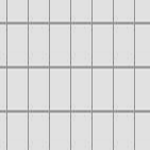

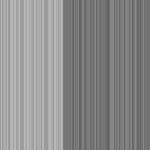

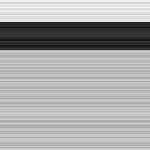

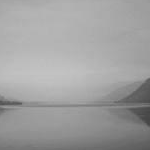

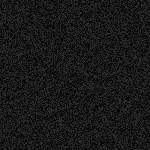

In [16]:
#Random background generation
for _ in range(5):
    display(Image.fromarray(dgen.get_background((150, 150))))

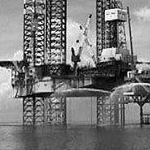

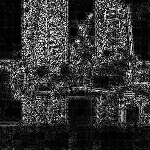

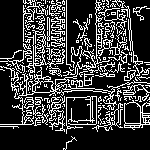

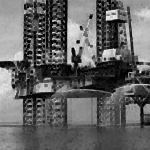

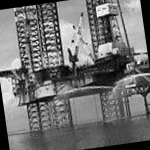

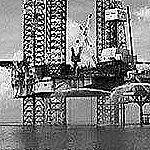

In [73]:
#Data augmentation samples, additional random orientation augmentation (flipping / 90 degree rotation) occurs during training
test = dgen.get_background((150, 150))

display(Image.fromarray(test))
for _ in range(5):
    display(Image.fromarray(dgen.img_warper(test)))

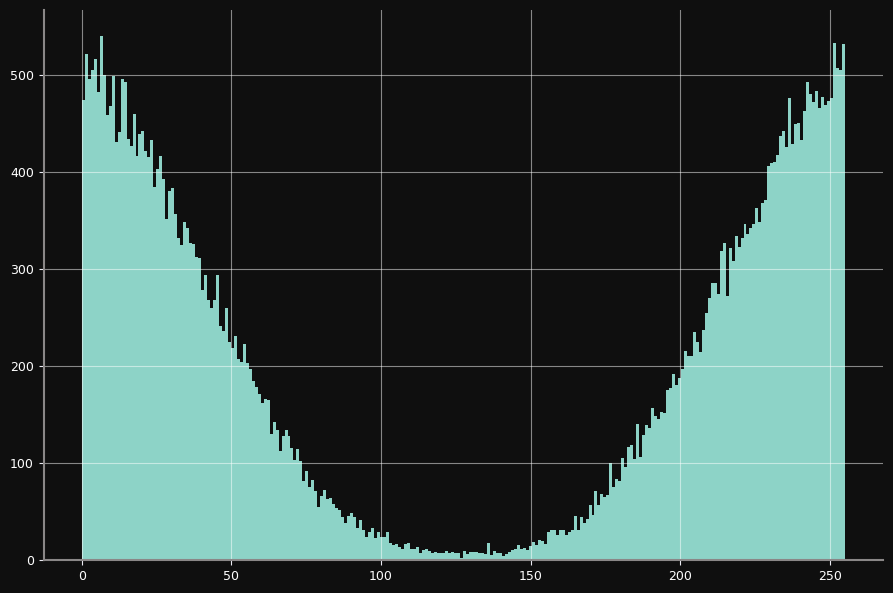

In [65]:
#Font color distribution
#The most frequently used text colors are black and white in real world data. Synthetic data should reflect this
bin = []
for _ in range(50000):
    bin.append(abs((255 * random.randint(0, 1)) - abs(np.random.randn() * 255 / (np.pi * 2))))

fig = plt.figure()
ax = plt.axes()
ax.hist(bin, 256)
plt.show()
#Background colors are chosen randomly chosen from a even distribution that excludes the font color and all values within a range of 16 around the font value in both directions
#Fonts and backgrounds that are within 16 points of one another are nearly illegible

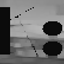

1

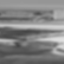

0

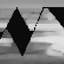

1

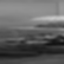

0

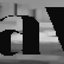

1

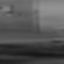

0

In [42]:
#Detection data samples
#Images containing text are labeled 1
tx, ty = dgen.gen_tdet_data(1, dgen.evalfonts, dgen.chars, True)
for i, x in enumerate(tx):
    display(Image.fromarray(x))
    display(ty[i])

In [4]:
#Segmentation data samples
#Images centered inbetween letters or on empty space are labeled 1
tx, ty = dgen.gen_tseg_data(1, dgen.trainfonts, dgen.chars, True)
tx, ty = btk.zshuffle(tx, ty)
for i, x in enumerate(tx):
    display(Image.fromarray(x))
    display(ty[i])

0

1

1

1

0

1

0

1

1

1

0

0

1

0

1

1

0

1

1

0

0

1

0

0

0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int8)

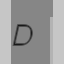

'D'

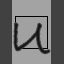

'U'

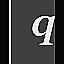

'q'

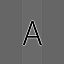

'A'

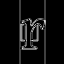

'r'

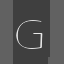

'G'

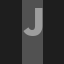

'J'

In [17]:
#Classification data samples
tx, ty = dgen.gen_tcls_data(7, dgen.chars, dgen.evalfonts, True, dgen.chars)
display(ty[0])
for i, x in enumerate(tx):
    display(Image.fromarray(x))
    display(dgen.chars_cased[ty[i].argmax()])

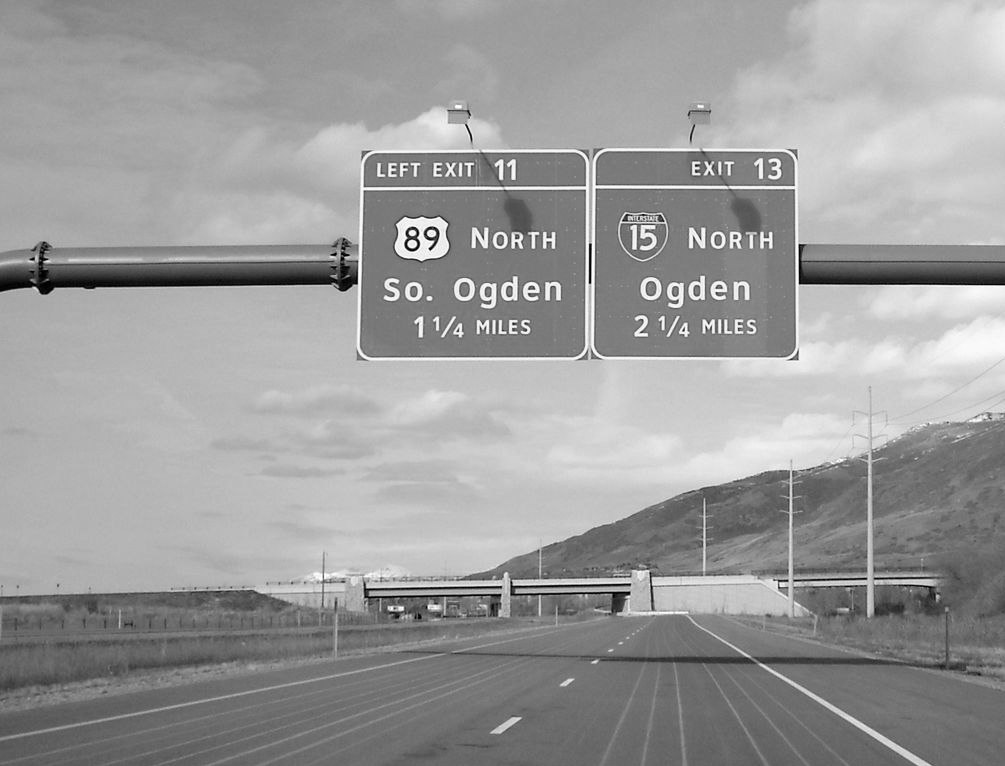

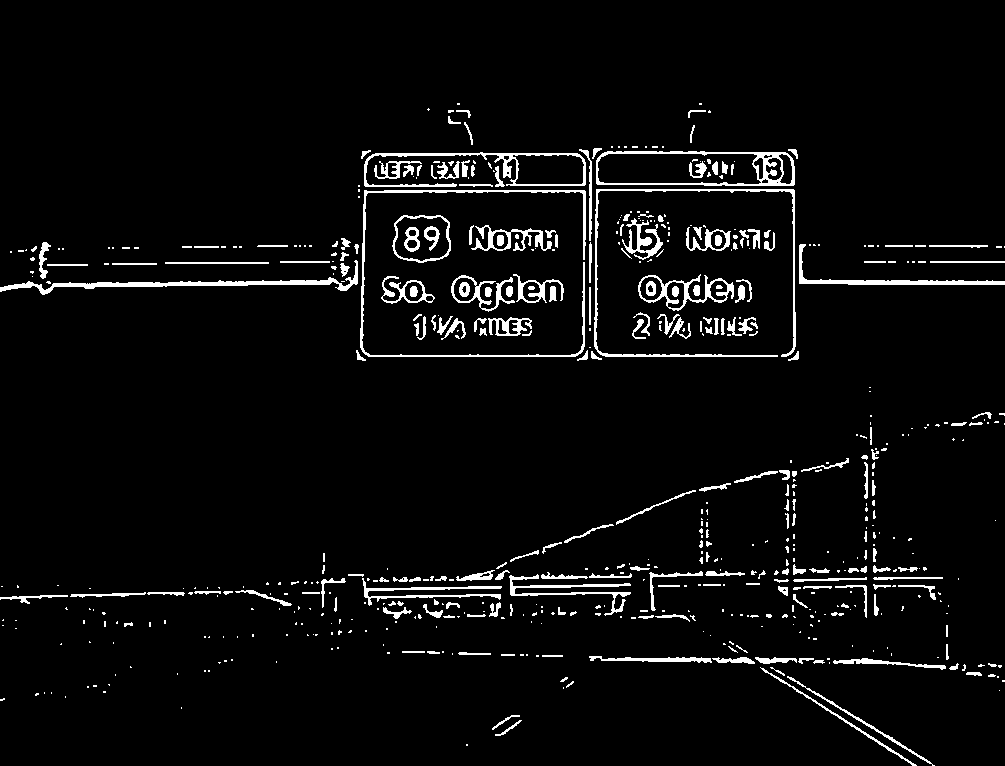

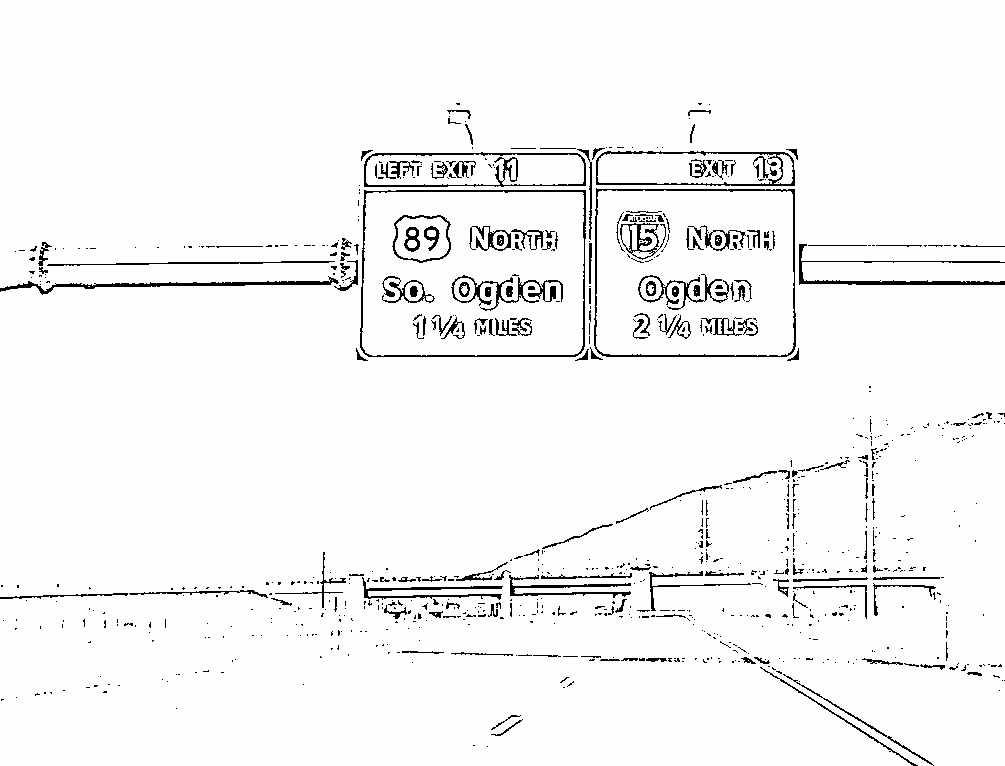

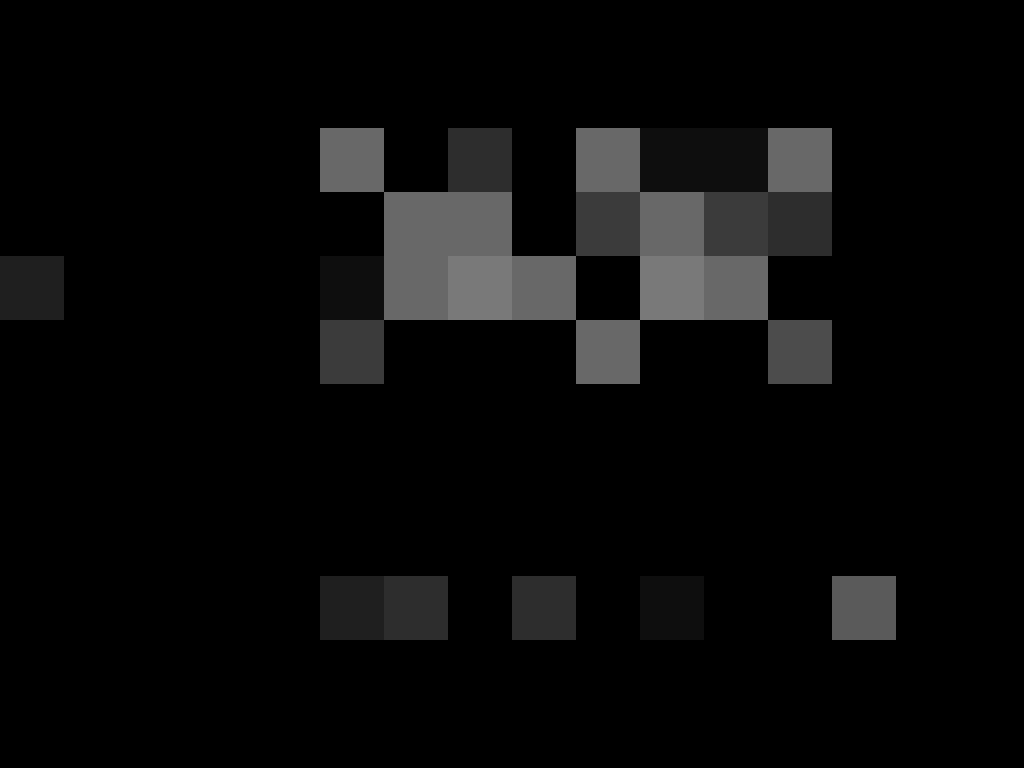

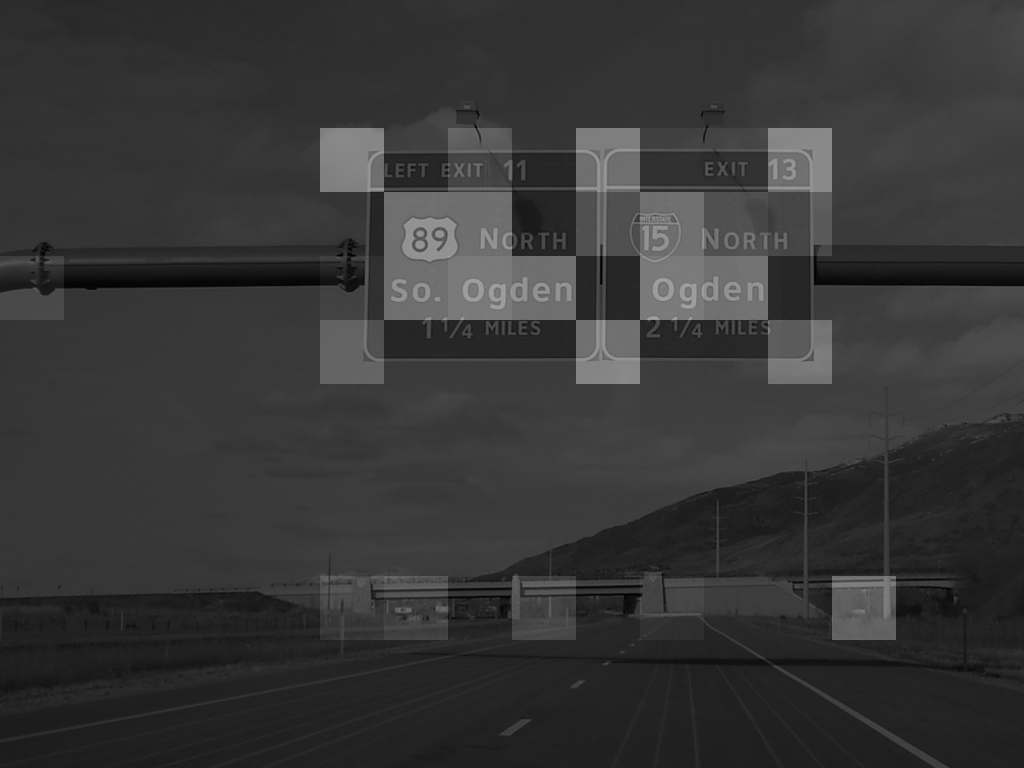

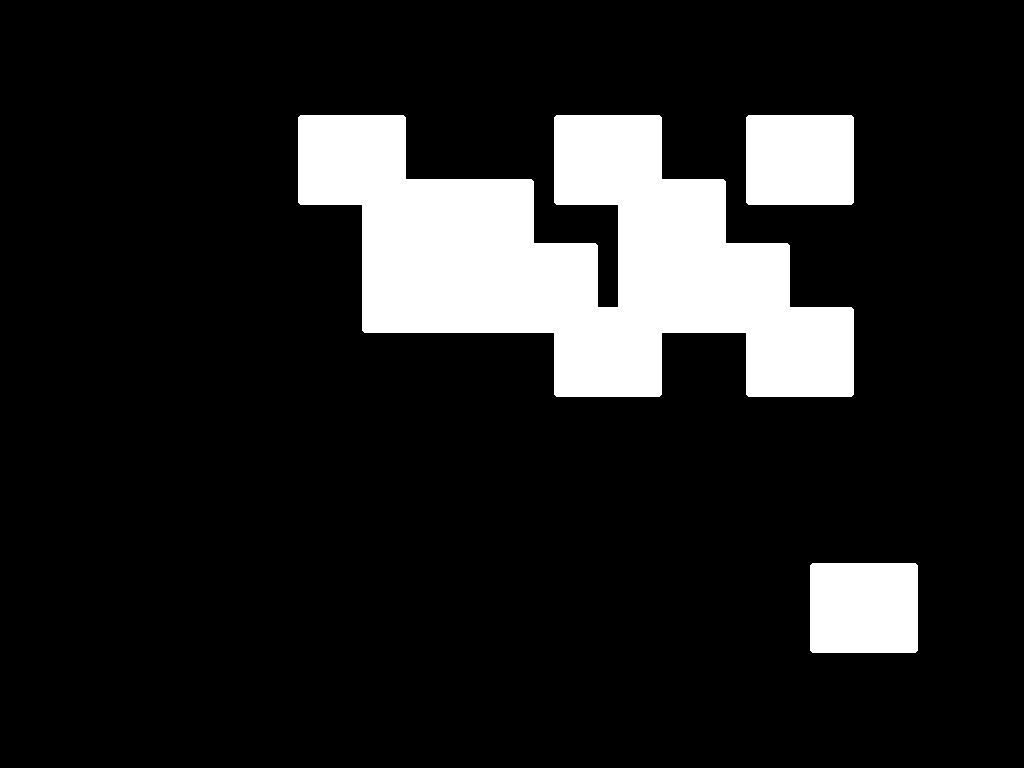

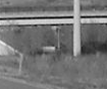

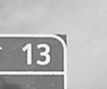

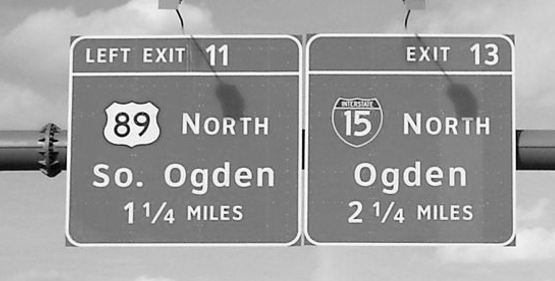

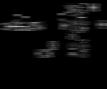

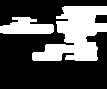

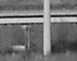

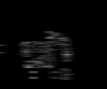

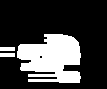

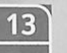

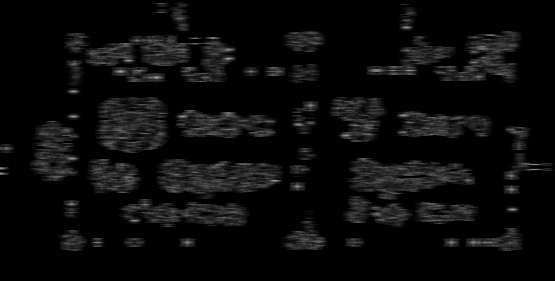

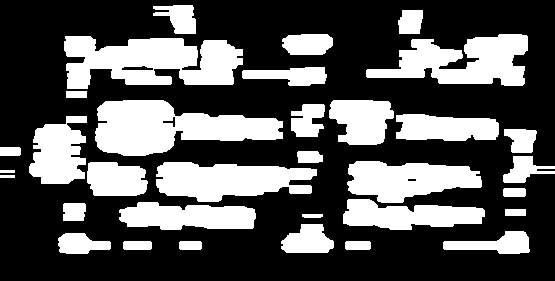

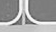

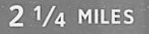

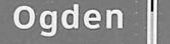

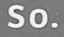

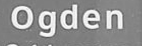

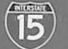

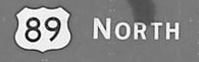

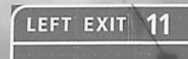

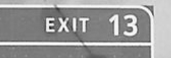

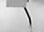

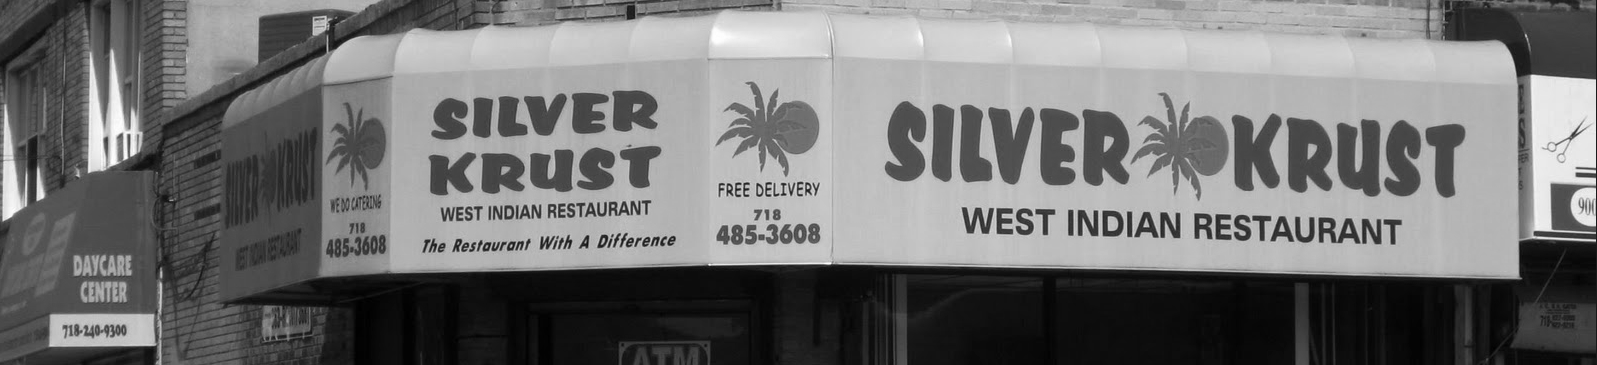

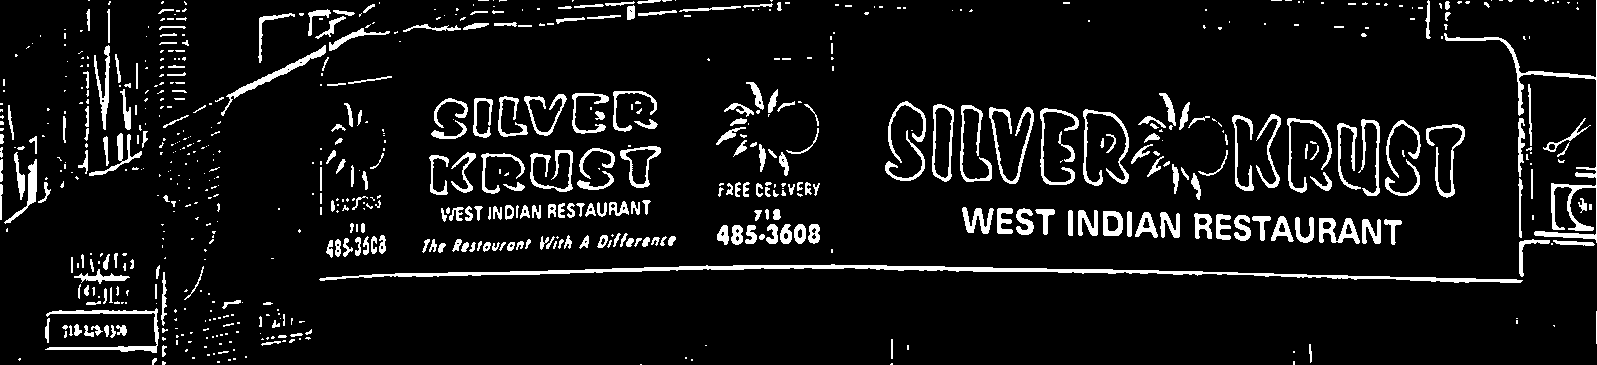

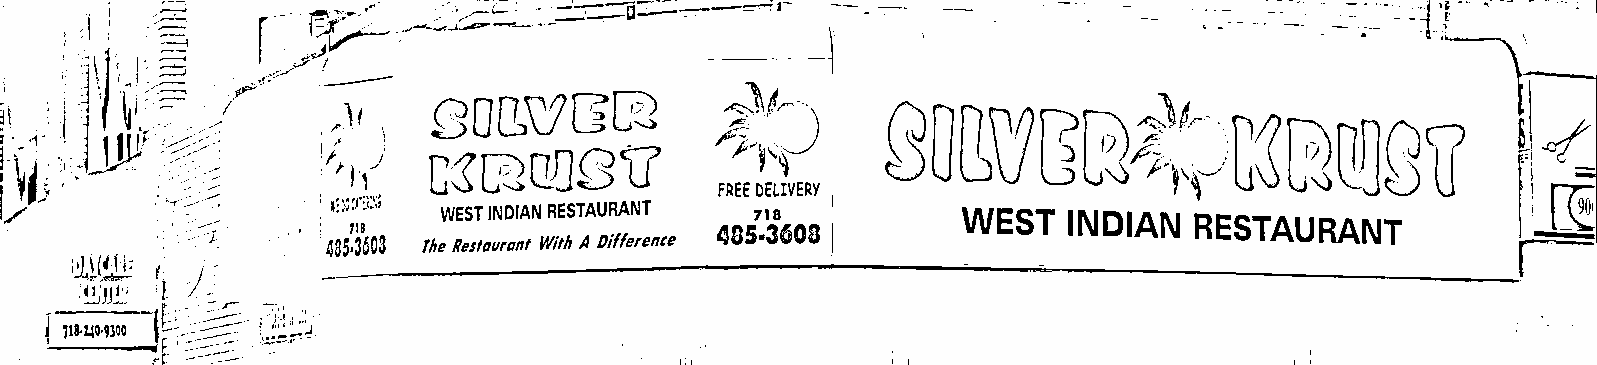

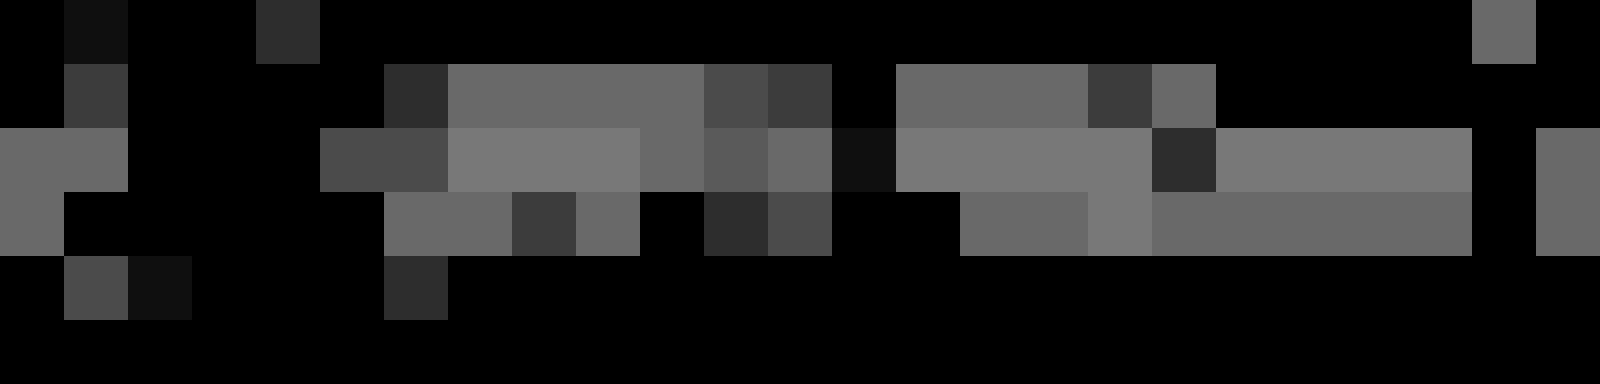

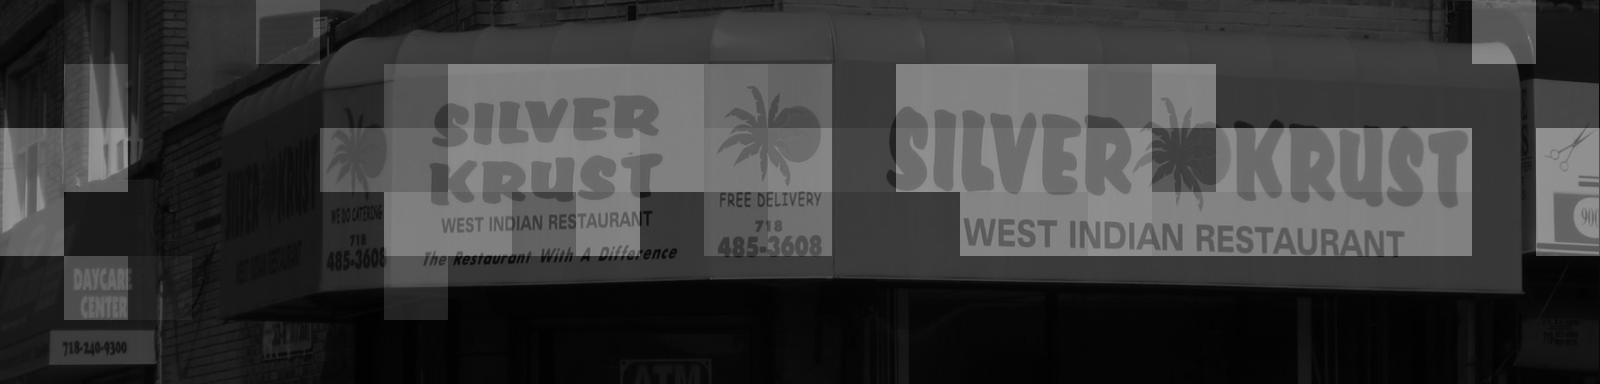

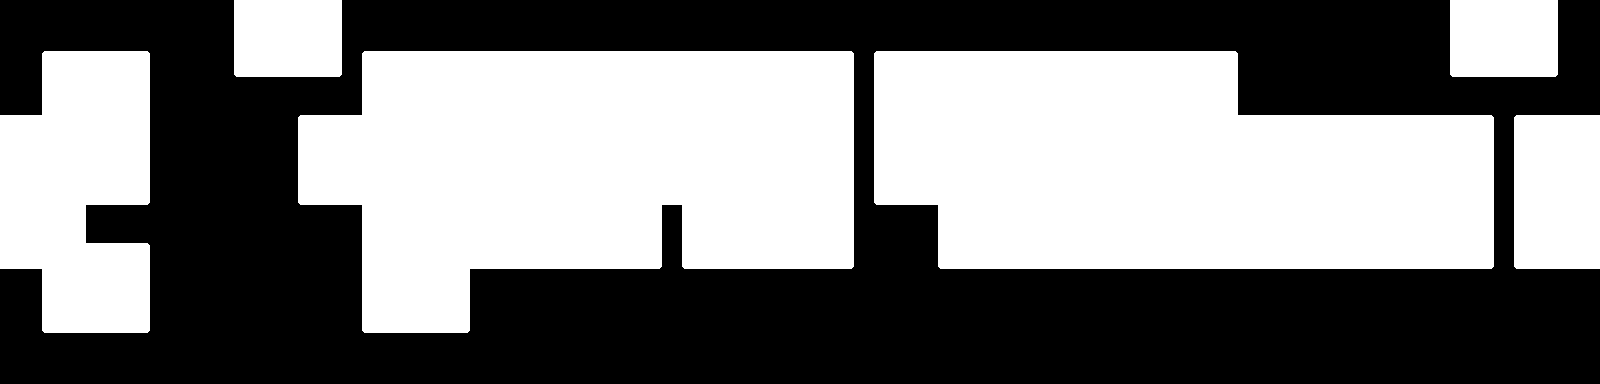

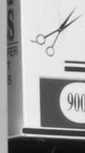

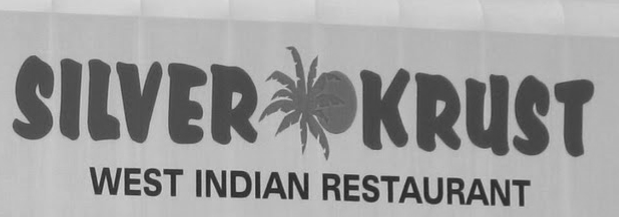

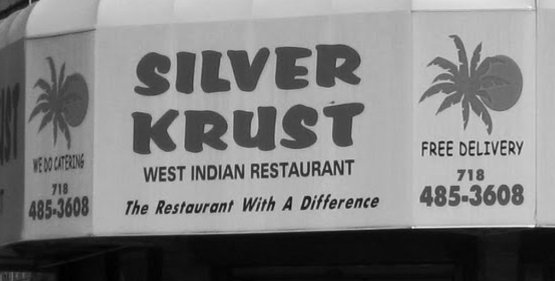

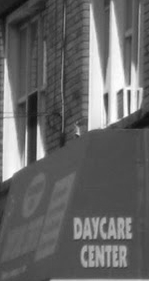

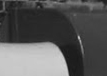

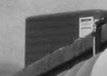

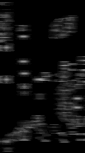

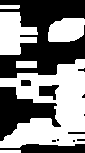

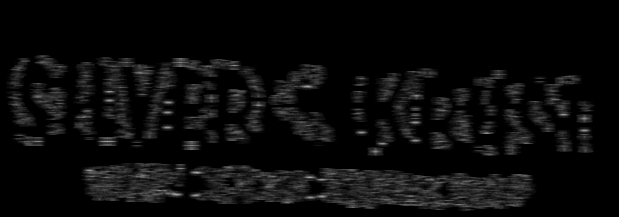

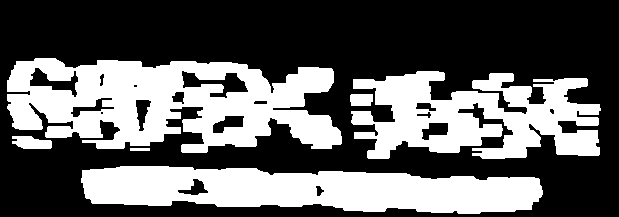

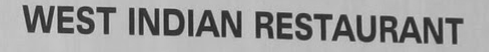

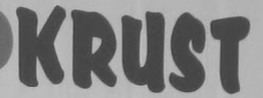

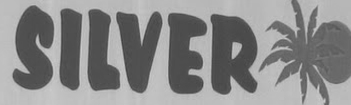

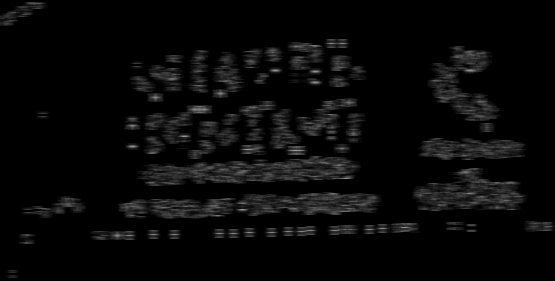

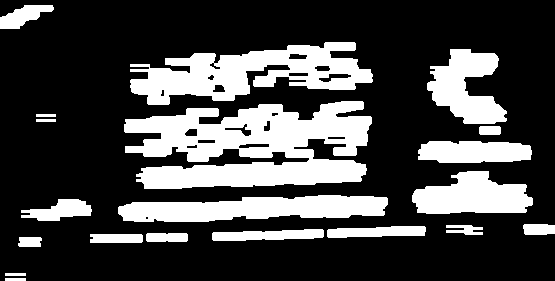

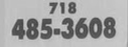

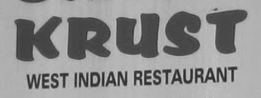

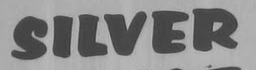

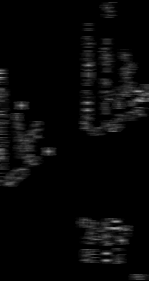

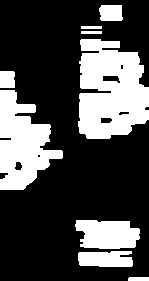

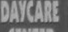

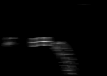

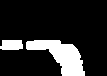

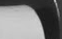

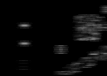

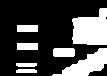

In [41]:
"""
Text Detection + Processing *WIP*

Images will be sliced into smaller pieces which will then be fed into the detection model.
Image slices that meet the probability threshold will be extracted from the image and proceed to the next step of processing

- High contrast straight edges were mislabeled often.
    Negative samples containing these features added to data for training.
- Images must be resized so that theyre dimensions are evenly divisible by the number of slices so that no information is lost
- Source image is resized and augmented multiple times to improve performance.
    Unsure if this is better than overlapping slices
- Probability regions from the different versions are combined on a heatmap
- Thresholding, blurring, and binarization are used to round out the text regions and ensure that no information is lost
- Additional processing focuses text regions on individual lines/words which can then be passed to the segmentation model

"""
tlist = [10, 32]
for x in tlist:
    with Image.open(f"testimgs\\t{x}.png") as f:
        iar = f
        display(Image.fromarray(btk.grey_np(iar)))
        regions = get_text(iar, (64, 64), 0.7)

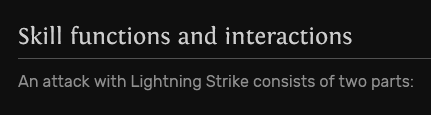

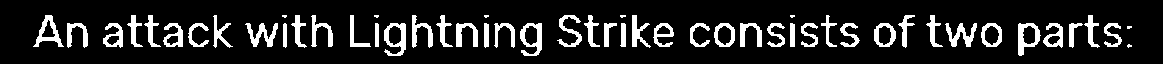

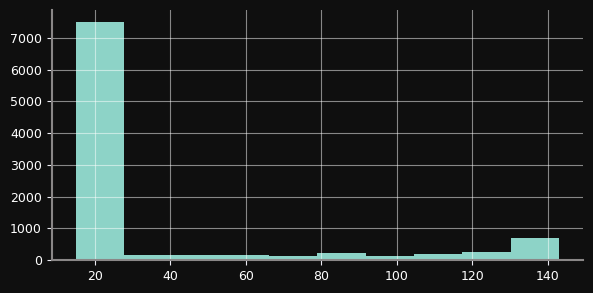

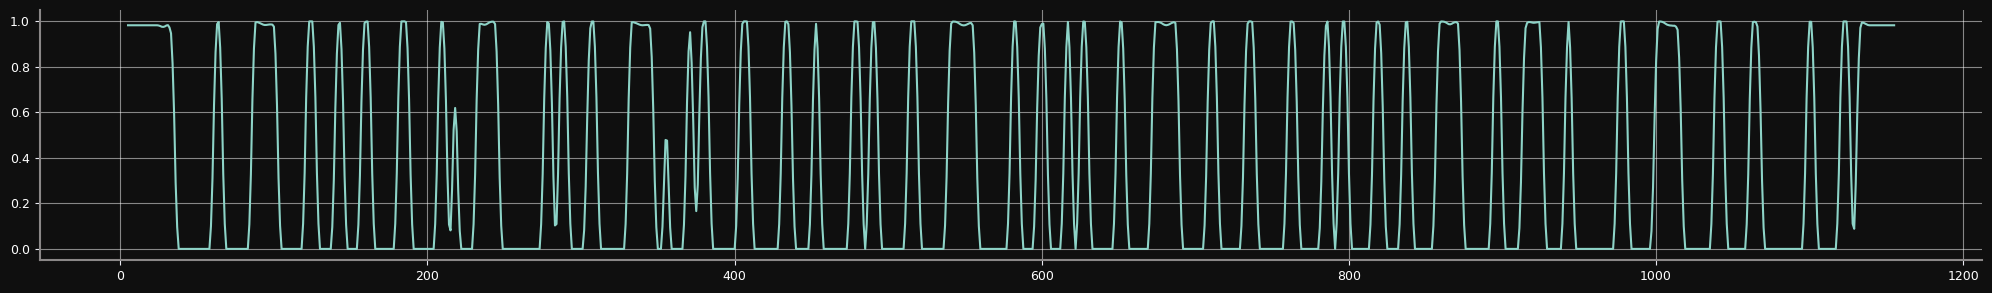

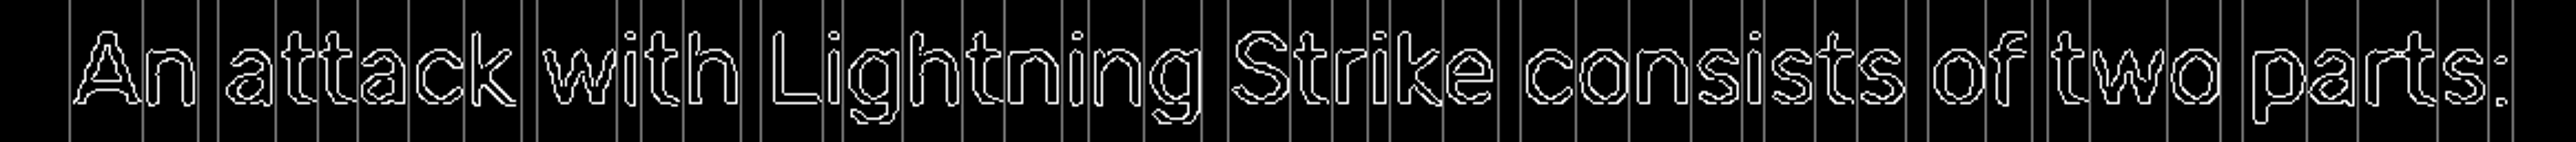

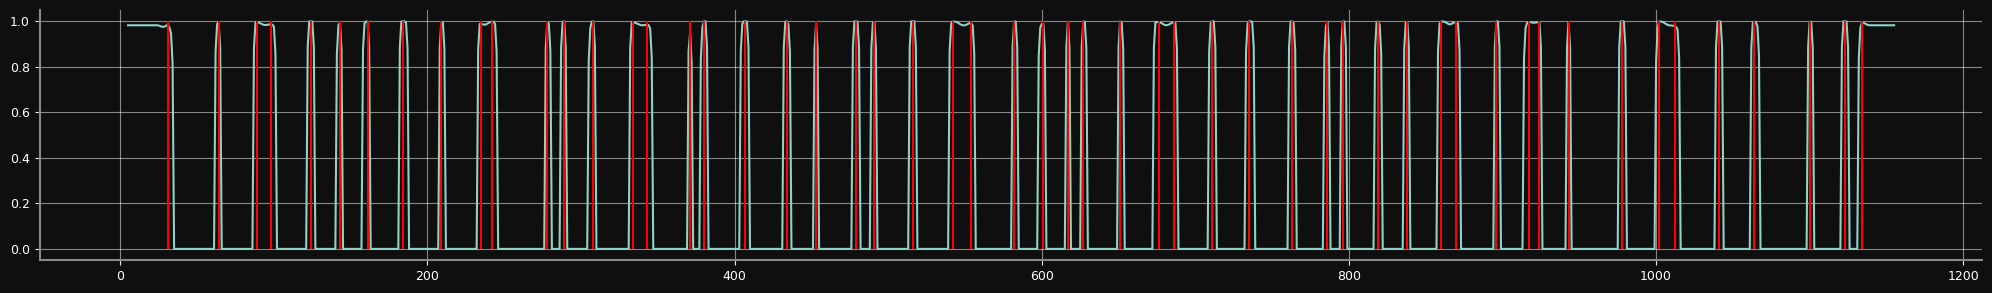

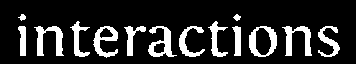

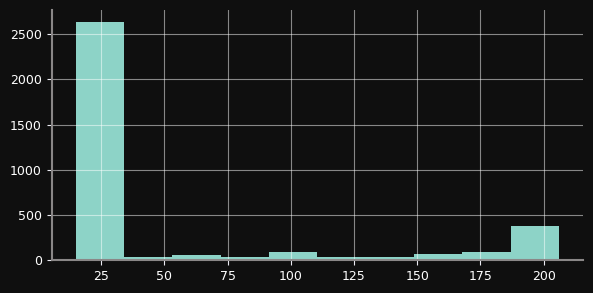

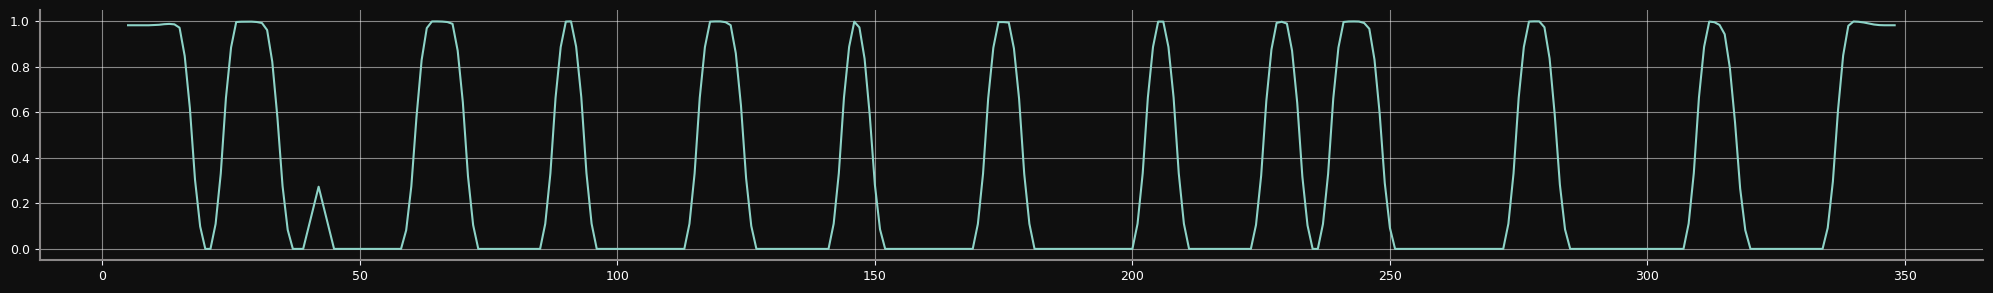

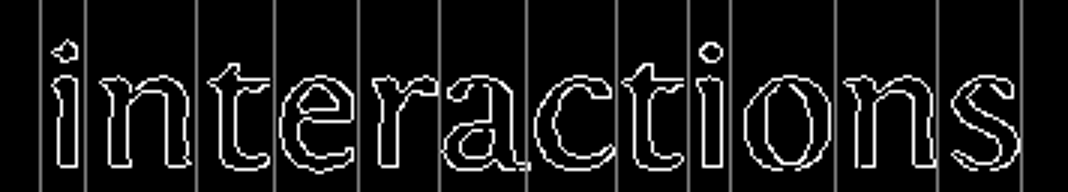

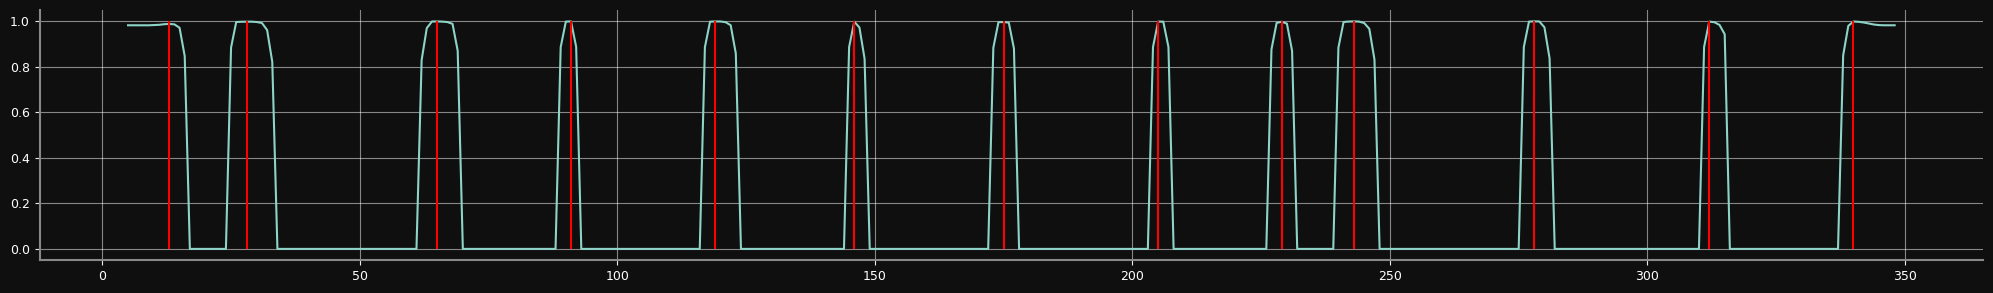

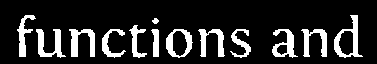

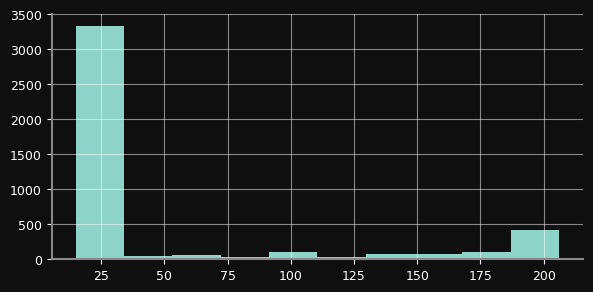

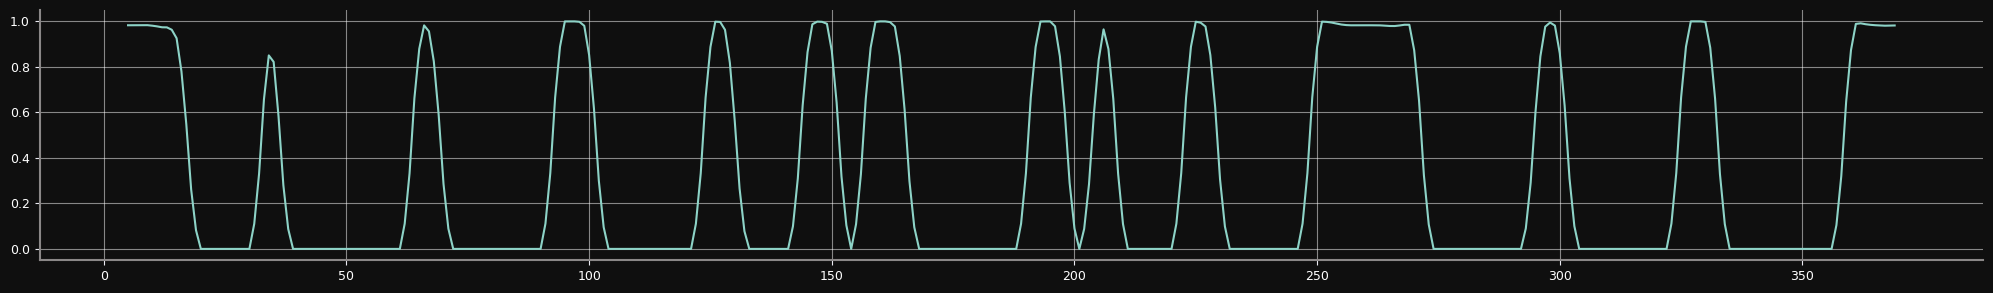

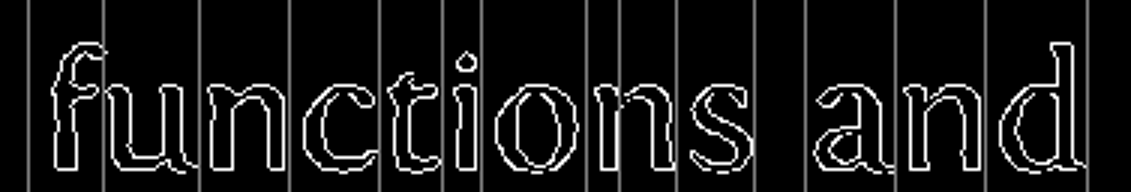

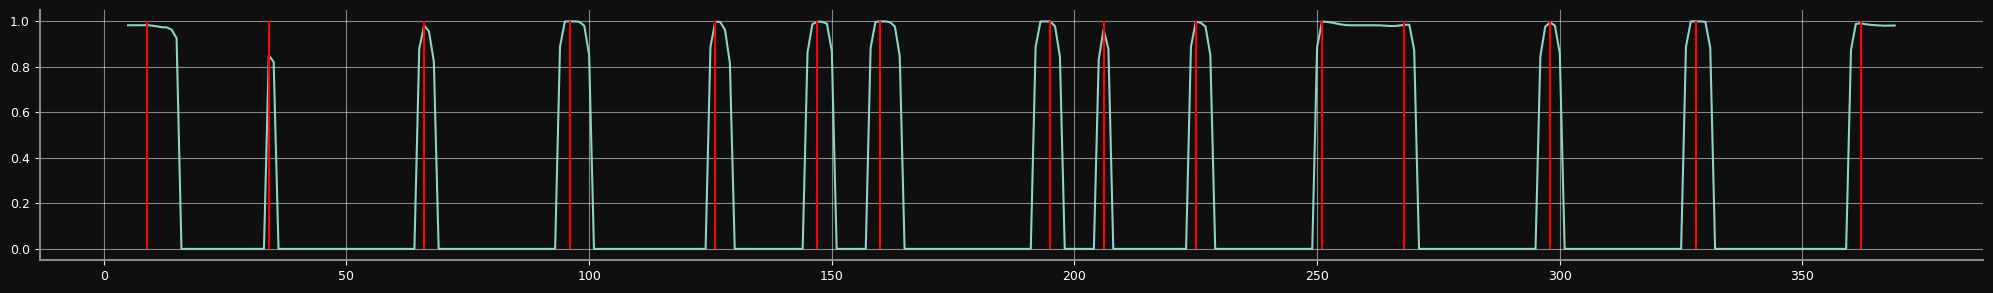

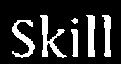

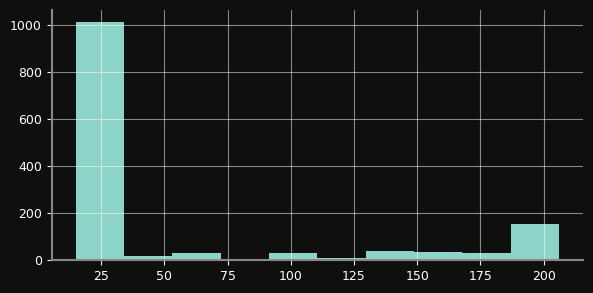

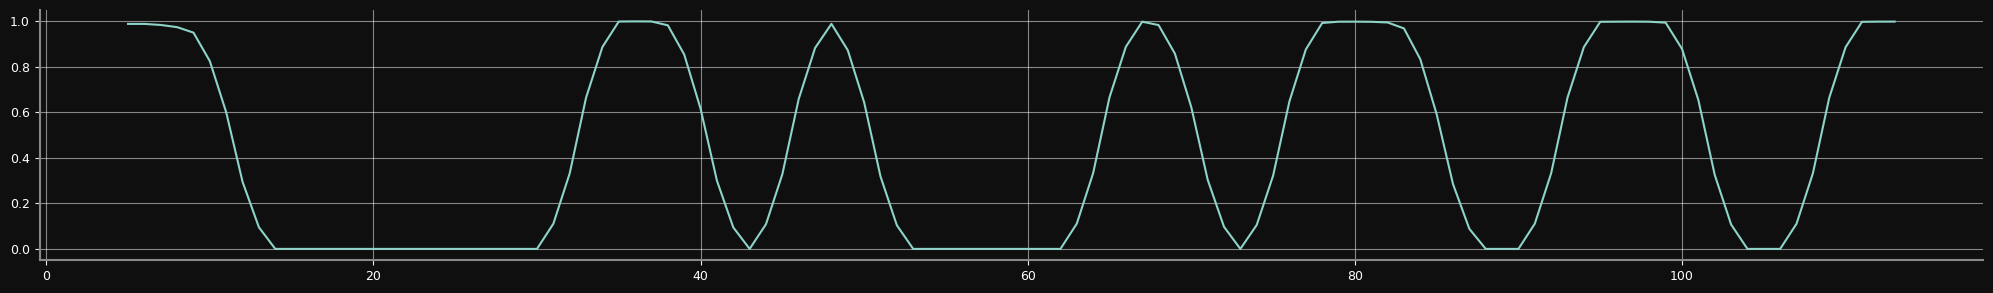

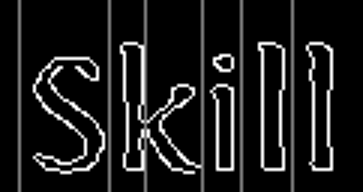

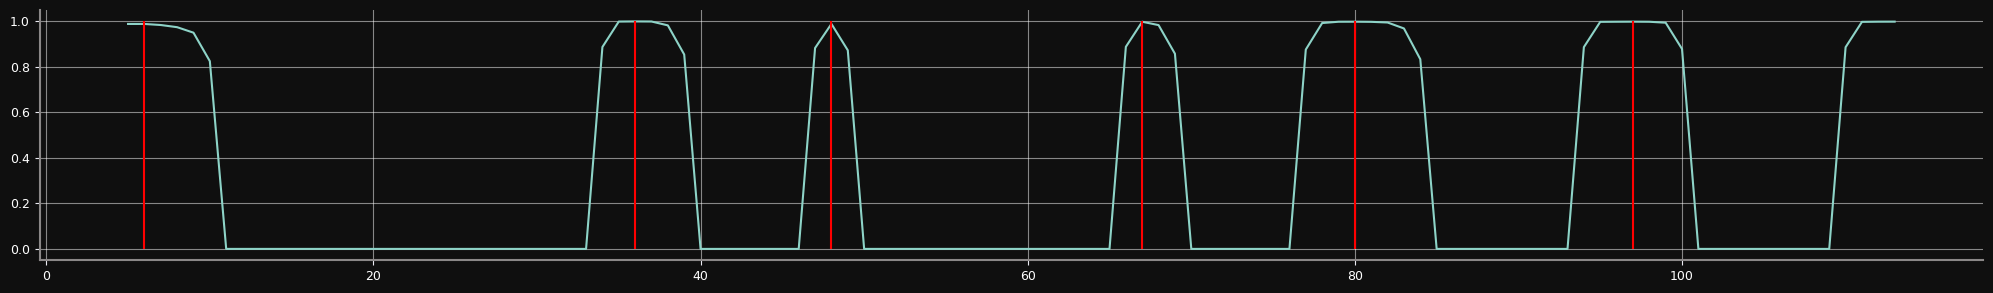

In [70]:
"""
Word Segmentation

Images of words will be sliced into a continuous series of thin images (step size 1) before being fed into the segmentation model
The model will return an array of continuous values that represent the probability of a region being a space between letters
The maximum critical points of this array are used to identify the exact pixel at which to slice

- Model had difficulty with certain letters (M, W, H, L, K) or combinations (li, ftr, TT).
    Datasets composed entirely of these letters added to improve performance.
- Canny edge detection applied to all images to isolate text and remove any background noise
- Extracted words are often surrounded by edges (borders on signs or text boxes) which interfere with the segmentation model
    Sobel filters applied to remove border elements before canny edge detection
- Letters in low resolution images have a tendancy to bleed into one another.
    The second most common pixel value usually indicates the primary text color.
        Setting all pixel values except the primary text color +(small range around) to 0 improves seperation while maintaining the shape of letter
- Occasionally adds extra spaces between letters
- Occasionally fails to seperate two characters
"""
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[50:250, :]
display(Image.fromarray(iar))
im = Image.fromarray(iar)
rows = extract_rows(iar)


for row in rows.values():
    fig = plt.figure()
    fig.set_size_inches(6, 3)
    ax = plt.axes()
    plt.hist(row.flatten(), 10)
    row = btk.force_dim(row, 64, 1)
    row = btk.sharpen(row)
    _, row = cv.threshold(row, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    row = row / 255
    row = cv.erode(row, (3, 3), 125, iterations=1)
    row = row.astype('uint8') * 255
    display(Image.fromarray(row))
    row = cv.Canny(row, 50, 200, apertureSize=3)
    slices = btk.img_slicer(row, (64, 12), 1, 1)
    idx = btk.gen_index(row.shape, (64, 12), 1, 1)
    preds = sp_predict(slices, 0.7)
    preds = np.array(btk.smooth_avg(btk.smooth_avg(preds)))
    fig = plt.figure()
    fig.set_size_inches(20, 3)
    ax = plt.axes()
    plt.plot(range(5, len(preds) + 5), preds)
    plt.show()
    preds[preds < 0.8] = 0
    crits = btk.criticals(preds, idx)
    crits = np.array([btk.halfpoint(x[0][0], x[0][1]) for x in crits if x[1] == 'max'])
    im = draw_sep(row, crits)
    display(im.resize((im.size[0] * 3, im.size[1] * 3)))
    fig = plt.figure()
    ax = plt.axes()
    fig.set_size_inches(20, 3)
    plt.plot(range(5, len(preds) + 5), preds)
    plt.vlines(crits, 0, 1, colors='r')
    plt.show()

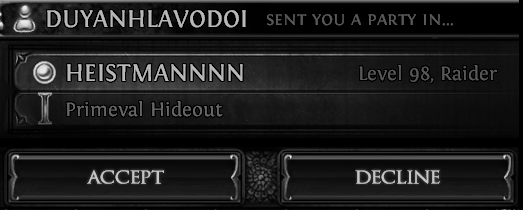

duyanhwodoi


 primeval hideout
accet  decline 
i
?
 7
sent you party ln...
 vodol
"o
)
-
c)
r
helstmannnn ' l-evel 98, raider


In [93]:
"""
Text Classification

Classify, organize and return a string representation of text

- Model has difficulty with certain letters
    Group 1 (I1li0oO)
        Expected due to randomization of data generation parameters. Performance for these characters matches human performance
        Additional data sets containing only these characters did not seem to improve performance significantly
    Group 2 (ZXWVSPOC)
        Letters are indistinguishable from their lowercase counterparts due to size randomization
        Implementation performance isnt adversely affected by guessing the wrong case
            All letters are eligible for generation but some capital letters (ZXWVSPOC) are excluded from the labels
            eg: "C" can appear as a generated character but it does not have a position in the label array. Both "C" and "c" are labeled as "c"
- I1liO0o letters are often used interchangably
    TODO Apply spell-check?
- Regions containing no letters are parsed creating excessive noise in the output
    TODO Apply interstage filtering
- Ordering needs to be fixed

"""
#tlist = [28, 16, 17, 15]
tlist = [28]

for x in tlist:
    with Image.open(f"testimgs\\t{x}.png") as f:
        iar = f
        display(Image.fromarray(btk.grey_np(iar)))
        readimg(f, 0.5, 0.9, 1, 1)